In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
image_dir = Path('C:/Users/daniel.brooks/Documents/Projects/Kaggle/Money_Fish/train')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Overall_Label') \
           .replace({'ALB': 'Albacore Tuna',
                    'BET': 'Big Eye Tuna',
                    'DOL': 'Mahi Mahi',
                    'LAG': 'Moonfish',
                    'SHARK': 'Shark',
                    'YFT': 'Yellow Fin Tuna',
                    'NoF': 'No Fish Present',
                    'OTHER': 'Other'})

image_df = pd.concat([filepaths, labels], axis=1)
shuffle_df = image_df.sample(frac=1).reset_index(drop = True)

In [3]:
round(image_df.groupby('Overall_Label')['Overall_Label'].count()/len(image_df)*100, 2)

Overall_Label
Albacore Tuna      45.51
Big Eye Tuna        5.30
Mahi Mahi           3.10
Moonfish            1.77
No Fish Present    12.31
Other               7.92
Shark               4.66
Yellow Fin Tuna    19.43
Name: Overall_Label, dtype: float64

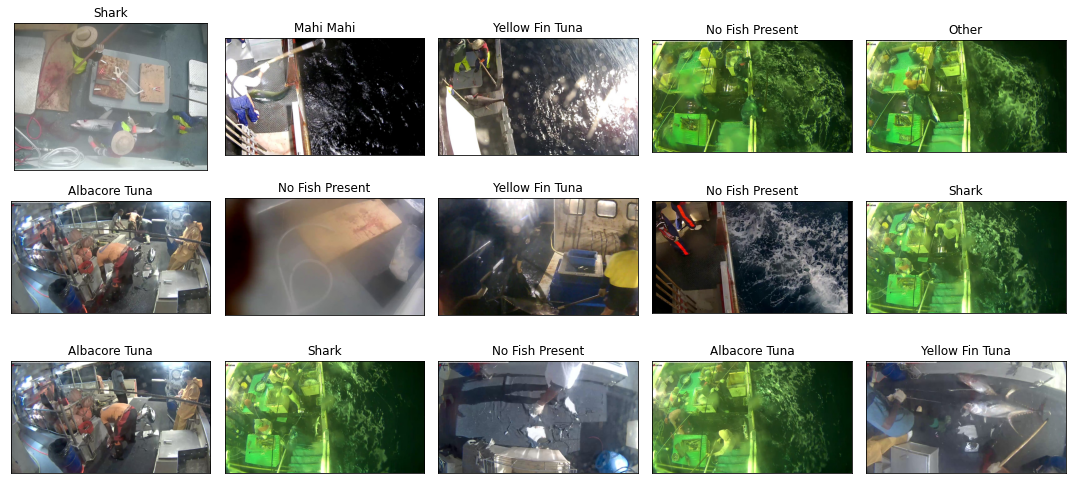

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(shuffle_df.Filepath[i]))
    ax.set_title(shuffle_df.Overall_Label[i])
plt.tight_layout()
plt.show()

In [5]:
image_df['Tuna_Label'] = ['Tuna' if re.search(r'Tuna', i) else "No Fish Present" 
                                 if re.search(r'Present', i) else "Other" 
                           for i in image_df['Overall_Label']]

In [6]:
round(image_df.groupby('Tuna_Label')['Tuna_Label'].count()/len(image_df)*100, 2)

Tuna_Label
No Fish Present    12.31
Other              17.45
Tuna               70.24
Name: Tuna_Label, dtype: float64

# Model Training

In [7]:
class_weights = {'No Fish Present': .40,
                 'Other': .40,
                 'Tuna': .20}

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1234)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Overall_Label',
    target_size=(720, 720),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Overall_Label',
    target_size=(720, 720),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Overall_Label',
    target_size=(720, 720),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2115 validated image filenames belonging to 8 classes.
Found 528 validated image filenames belonging to 8 classes.
Found 1134 validated image filenames belonging to 8 classes.


In [8]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), padding='valid', input_shape=(720, 720, 3), activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),    
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'), 
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'), 
    Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    Flatten(),
    #BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation = 'relu'),
    Dropout(0.4),
    Dense(512, activation = 'relu'),
    Dense(8, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 64)      23296     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 43, 43, 128)       2

In [9]:
tf.keras.backend.clear_session()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0005), metrics = ["accuracy"])
model_history = model.fit(train_images, epochs=15, callbacks =[reduce_lr], validation_data = val_images)

Epoch 1/15
67/67 [==============================] - 278s 4s/step - loss: 3.5658 - accuracy: 0.3824 - val_loss: 1.8996 - val_accuracy: 0.5852
Epoch 2/15
67/67 [==============================] - 288s 4s/step - loss: 1.8345 - accuracy: 0.5654 - val_loss: 1.2481 - val_accuracy: 0.7140
Epoch 3/15
67/67 [==============================] - 302s 5s/step - loss: 1.1769 - accuracy: 0.7453 - val_loss: 0.7556 - val_accuracy: 0.8598
Epoch 4/15
67/67 [==============================] - 306s 5s/step - loss: 0.7215 - accuracy: 0.8778 - val_loss: 0.5453 - val_accuracy: 0.9072
Epoch 5/15
67/67 [==============================] - 308s 5s/step - loss: 0.4506 - accuracy: 0.9365 - val_loss: 0.4743 - val_accuracy: 0.9261
Epoch 6/15
67/67 [==============================] - 308s 5s/step - loss: 0.3685 - accuracy: 0.9542 - val_loss: 0.4382 - val_accuracy: 0.9318
Epoch 7/15
67/67 [==============================] - 309s 5s/step - loss: 0.2601 - accuracy: 0.9730 - val_loss: 0.3786 - val_accuracy: 0.9356
Epoch 8/15
67

In [10]:
scoreSeg = model.evaluate(x=test_images,verbose =1)

36/36 [==============================] - 40s 1s/step - loss: 0.3799 - accuracy: 0.9347


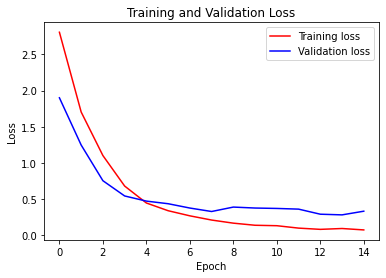

In [11]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
EPOCHS =15
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

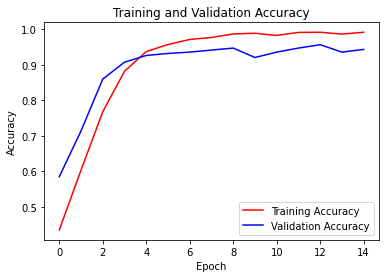

In [12]:
loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']
EPOCHS =15
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
test_predictions = model.predict(test_images)
test_predictions = np.argmax(test_predictions, axis=1)

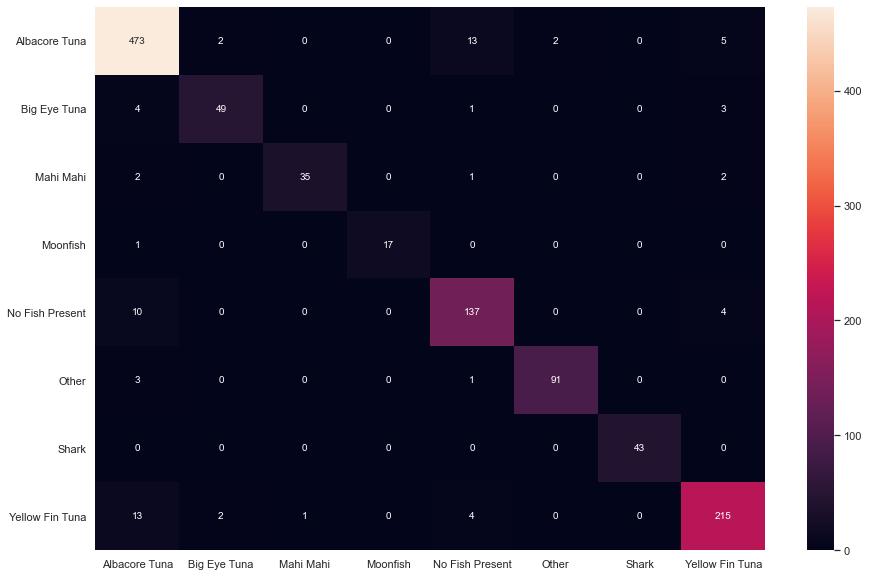

In [14]:
cnf_matrix = confusion_matrix(test_images.labels, test_predictions)
df = pd.DataFrame(cnf_matrix, train_images.class_indices.keys(), train_images.class_indices.keys())

plt.figure(figsize=(15,10))
sns.set(font_scale=1.0) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 10},fmt='d') # font size

plt.show()

# Kaggle Submission

In [15]:
image_dir_test = Path('C:/Users/daniel.brooks/Documents/Projects/Kaggle/Money_Fish/test')
filepaths_test = list(image_dir_test.glob(r'**/*.jpg'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))

filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
labels_test = pd.Series(labels_test, name='Overall_Label')

image_df_test = pd.concat([filepaths_test, labels_test], axis=1)
shuffle_df_test = image_df_test.sample(frac=1).reset_index(drop = True)

In [16]:
final_images = test_generator.flow_from_dataframe(
    dataframe=shuffle_df_test,
    x_col='Filepath',
    y_col='Overall_Label',
    target_size=(720, 720),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1000 validated image filenames belonging to 1 classes.


In [17]:
output_df = pd.DataFrame(model.predict(final_images), columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
output_df = pd.concat([shuffle_df_test['Filepath'], output_df], axis=1) \
              .rename(columns={'Filepath': 'image'})

output_df['image'] = list(map(lambda x: os.path.split(x)[1], output_df['image']))

In [18]:
image_dir_test = Path('C:/Users/daniel.brooks/Documents/Projects/Kaggle/Money_Fish/test_stg2/test_stg2')
filepaths_test = list(image_dir_test.glob(r'**/*.jpg'))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))

filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
labels_test = pd.Series(labels_test, name='Overall_Label')

image_df_test = pd.concat([filepaths_test, labels_test], axis=1)
shuffle_df_test = image_df_test.sample(frac=1).reset_index(drop = True)

In [19]:
final_images = test_generator.flow_from_dataframe(
    dataframe=shuffle_df_test,
    x_col='Filepath',
    y_col='Overall_Label',
    target_size=(720, 720),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12153 validated image filenames belonging to 1 classes.


In [32]:
output_df_2 = pd.DataFrame(model.predict(final_images), columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
output_df_2 = pd.concat([shuffle_df_test['Filepath'], output_df_2], axis=1) \
             .rename(columns={'Filepath': 'image'})

output_df_2['image'] = list(map(lambda x: os.path.split(x)[1], output_df_2['image']))

In [33]:
final = pd.concat([output_df, output_df_2], axis=0)
final.to_csv('C:/Users/daniel.brooks/Documents/Projects/Kaggle/Money_Fish/Submission_1.csv')